In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt

# Required contact tracing intensity to reach $R_0=1$ in SAIQR model

We consider an SAIQR model: infections splitting between asymptomatic infectives $A$ and infectives who are symptomatic (or by some other means, are eligible for being identified, quarantined, and contact-traced). We'll write up the equations separately. I'll just list the parameters here:

* $\alpha$: the symptomatic rate: if $\alpha=1$ every infection goes to $I$, if it's $0$, every infection goes to $A$
* $\beta_0$: the infective rate. Currently this is the same for both $A$ and $I$. Perhaps this needs to be split in $\beta_{0,a}$ and $\beta_{0,i}$.
* $\gamma_a, \gamma_i$: the recovery rates from (i.e., the reciprocal of the average infective durations) for $A$ and $I$ respectively.
* $\kappa_q$: the reciprocal of the average time until symptom onset (i.e., the quarantining rate).
* $C_d$: distancing measures. This just scales $\beta_0$ by $(1-C_d)$.
* $C_q$: compliance with quarantine. So, the combined outflow rate from $I$ due to recovery and quarantining is $\kappa_q C_q + \gamma_i (1-C_q)$. In addition $\kappa_q C_q$ also contributes to the stream of people that can be contact traced.
* $C_s$: surveillance testing rate. This samples from both $A$ and $I$, proportional to their sizes and also contributes to the stream of contact-traceable people.

The tricky part is that the balance between $A$ and $I$ is also dependent on the measures taken, because a higher $C_q$ probably means a higher outflow from $I$ and hence a reduced number for $I/(A+I)$. The complicated part of the formula (the square root) comes from balancing this, to find a fixed point $\lambda=I/(A+I)$ under the dynamics in force. This can deviate considerably from the $\alpha$ you would guess based on the inflows.

We compute $R_0$ without contact tracing, and we solve $C_t$ from $R_0(1-C_t)=1$. $C_t$ can be interpreted as the proportion of the infected flow that would need to be fully contact traced in order to get $R_0=1$ (it's the factor by which the infection graph needs to be pruned in order to reach average branching degree $1$). We don't actually get to contact-trace everyone: only those people who end up in quarantine; so with $C_s=0$, the actual amount of full contact tracing we need to do is
$$\tau=\frac{C_t((\kappa_q C_q)+(1-C_q)\gamma_i))}{\lambda\kappa_qC_q}.$$
Assuming that the effect of contact tracing is roughly linear in the per-step efficiency of it (which is a somewhat reasonable assumption, based on experiments), we can interpret $\tau$ as the efficiency level of contact tracing that is required. 

In [2]:
def compute_tau(alpha,beta0,gamma_i,gamma_a,kappa_q, Cd, Cq, Cs):
    kappaI = Cq*kappa_q+Cs
    u = kappaI + (1-Cq)*gamma_i
    kappaA = Cs
    v = kappaA + gamma_a
    w = u-v
    beta1=beta0*(1-Cd)
    R0=(2*beta1/(beta1+u+v-sqrt(beta1**2-4*(alpha-1/2)*beta1*(u-v)+(u-v)**2)))
    Ct=1-1/R0
    beta=beta1*(1-Ct)
    L=(1/(2*w)*(beta+w-sqrt(w**2-4*(alpha-1/2)*beta*w+beta**2)))
    tau= Ct/(kappaI/u * L + kappaA/v *(1-L))
    return tau

## example disease:
We set the basic $R_0=3$ and assume equal recovery rates $\gamma_i=\gamma_a=0.1$ (i.e., disease length $10$ days) and $\kappa_q=0.2$ (i.e. symptom onset $5$ days). For $\alpha=0.1,0.2,\ldots,0.9$ we plot the required $\tau$ as function of $R_0$. There should be a legend to the plot below for the $\alpha$, but the idea is clear: larger values of $\alpha$ are easier to control, so lead to a graph for $\tau$ that is more to the left/below relative to the others. In particular, we see that with these parameters, for $\alpha >0.7$ it could be that contact tracing alone does the job. 

In [3]:
xrange=np.arange(0.01,1,0.01)
alpharange=np.arange(0.1,1,0.1)
tau_range=[[compute_tau(alpha=b,beta0=3/10,gamma_i=1/10,gamma_a=1/10,kappa_q=0.2,Cd=x,Cq=1,Cs=0) for x in xrange] for b in alpharange]

Text(0.5, 1.0, 'Contact tracing required to reach R0=1, as function of distancing')

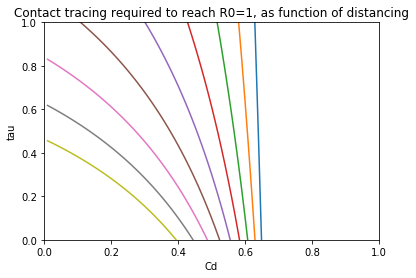

In [4]:
fig,ax=plt.subplots()
[ax.plot(xrange,t) for t in tau_range] 
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel("Cd")
ax.set_ylabel("tau")
ax.set_title("Contact tracing required to reach R0=1, as function of distancing")